In [54]:
base_path = '../'

In [ ]:
# p = ['downward-dog',
# 'high-lunge',
# 'low-lunge',
# 'warrior-3',
# 'side-plank',
# 'balancing-table',
# 'child',
# 'tree',
# 'extended-triangle',
# 'bridge']

# for 

In [55]:

import os

# Gets label
csv_path = os.path.join(base_path,'data/3DYoga90_corrected.csv')

# Gets valid samples
sequence_path = os.path.join(base_path, 'short/downloaded_log.txt')

# Path to save the model
# save_path = os.path.join(base_path, 'nov11_bi_lstm')
# os.makedirs(save_path, exist_ok=True)

# Classification classes
pose_list = ['mountain', 'half-way-lift', 'standing-forward-bend', 'downward-dog']
NUM_CLASSES = len(pose_list)

# Original Downloaded Seqeuence
video_dir = os.path.join(base_path, 'short')

# Pre_processed to tensor to make training fast # Makes video_dir redundant
preprocessed_dir = os.path.join(base_path, 'complete_pre_processed')
# os.makedirs(preprocessed_dir, exist_ok=True)
assert os.path.isdir(preprocessed_dir), f"Directory '{preprocessed_dir}' does not exist."

# # Horizontal Flip
# horz_aug = os.path.join(base_path, 'horz_aug')
# assert os.path.isdir(horz_aug), f"Directory '{horz_aug}' does not exist."

# # Gaussian Blur
# gaussian_blur_aug = os.path.join(base_path, 'gaussian_blur_aug')
# assert os.path.isdir(gaussian_blur_aug), f"Directory '{gaussian_blur_aug}' does not exist."

# # Random Resize Crop
# resize_aug = os.path.join(base_path, 'complete_pre_processed')
# assert os.path.isdir(resize_aug), f"Directory '{resize_aug}' does not exist."


In [56]:
# Constants
FRAME_HEIGHT = 224
FRAME_WIDTH = 224
SEQUENCE_LENGTH = 16

BATCH_SIZE = 16
LEARNING_RATE = 0.0001
VALIDATION_SPLIT = 0.2
TEST_SPLIT = 0.1
NUM_EPOCHS = 50

In [68]:

import os
import torch
import pandas as pd
import numpy as np
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import imageio
import random

class YogaVideoDataset(Dataset):
    def __init__(self, csv_path, sequence_path, pose_list, video_dir, preprocessed_dir, aug_dirs, use_augmented=True, aug_probability=0.5):
        with open(sequence_path) as f:
            sequence_list = f.read().splitlines()
            sequence_list = [int(x) for x in sequence_list]

        self.df = pd.read_csv(csv_path)
        self.df = self.df[self.df['sequence_id'].isin(sequence_list)]
        # self.df = self.df[self.df['l3_pose'].isin(pose_list)]

        self.pose_to_idx = {pose: idx for idx, pose in enumerate(pose_list)}
        self.length_of_dataset = len(self.df)

        self.video_dir = video_dir
        self.preprocessed_dir = preprocessed_dir
        self.aug_dirs = aug_dirs  # Dictionary of augmentation directories
        self.use_augmented = use_augmented
        self.aug_probability = aug_probability

        # os.makedirs(self.preprocessed_dir, exist_ok=True)

        self.transforms = transforms.Compose([
            transforms.Resize((FRAME_HEIGHT, FRAME_WIDTH)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        self.cache = dict()

    
    def __len__(self):
        return self.length_of_dataset

    def __getitem__(self, i):
        sequence_id = self.df.iloc[i]['sequence_id']
        pose = self.df.iloc[i]['l3_pose']
        label = self.pose_to_idx[pose]
        sequence_duration = self.df.iloc[i]['sequence_duration']


        # frames = torch.randn((1))
        return pose, sequence_duration

    def _get_frames(self, video_path):
        reader = imageio.get_reader(video_path, 'ffmpeg')
        fps = imageio.get_reader(video_path, 'ffmpeg').get_meta_data()['fps'] // 1
        total_frames = reader.count_frames()

        # print(fps)
        # print(total_frames)
        # Sample SEQUENCE_LENGTH = 7 frames per second
        # indices = np.linspace(0, fps - 1, SEQUENCE_LENGTH, dtype=int)
        # print(video_path)
        indices = np.arange(0, fps - 1, fps // SEQUENCE_LENGTH, dtype=int)

        # print(indices)
        frames = []
        for i, frame in enumerate(reader):
            if i % fps in indices:
                frame = Image.fromarray(frame)
                frame = self.transforms(frame)
                frames.append(frame)
                # print('Frame number', i % fps, 'Frame', i)

        reader.close()
        # print('Frame Length', len(frames))
        frames = torch.stack(frames)
        return frames

In [58]:
# Add this import at the top of your file if not already present
import matplotlib.pyplot as plt

# Add this function to your code
def plot_dataset_statistics(train_dataset, val_dataset, test_dataset):
    # Calculate the number of samples in each dataset
    num_train_samples = len(train_dataset)
    num_val_samples = len(val_dataset)
    num_test_samples = len(test_dataset)

    # Data for plotting
    categories = ['Training', 'Validation', 'Test']
    counts = [num_train_samples, num_val_samples, num_test_samples]

    # Create a bar plot
    plt.figure(figsize=(8, 5))
    plt.bar(categories, counts, color=['blue', 'orange', 'green'])
    plt.title('Dataset Statistics')
    plt.xlabel('Dataset Split')
    plt.ylabel('Number of Samples')
    plt.ylim(0, max(counts) + 10)  # Add some space above the highest bar
    plt.grid(axis='y')

    # Show the plot
    plt.show()

In [59]:

from torch.utils.data import random_split

def train_val_test_split(dataset):
    total_size = len(dataset)
    test_size = int(TEST_SPLIT * total_size)
    val_size = int(VALIDATION_SPLIT * total_size)
    train_size = total_size - val_size - test_size

    train_dataset, val_dataset, test_dataset = random_split(
        dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)  # For reproducibility
    )

    return train_dataset, val_dataset, test_dataset

In [67]:
dataset = YogaVideoDataset(csv_path, sequence_path, pose_list, video_dir, preprocessed_dir, {})

train_d, val_d, test_d = train_val_test_split(dataset)

1147


In [61]:
dataset_stats = {
    key: [0, 0] for key in pose_list
}
for label, seq_duration in dataset:
    dataset_stats[label][0] += 1
    dataset_stats[label][1] += seq_duration
dataset_stats

{'mountain': [133, 484],
 'half-way-lift': [171, 486],
 'standing-forward-bend': [185, 791],
 'downward-dog': [203, 968]}

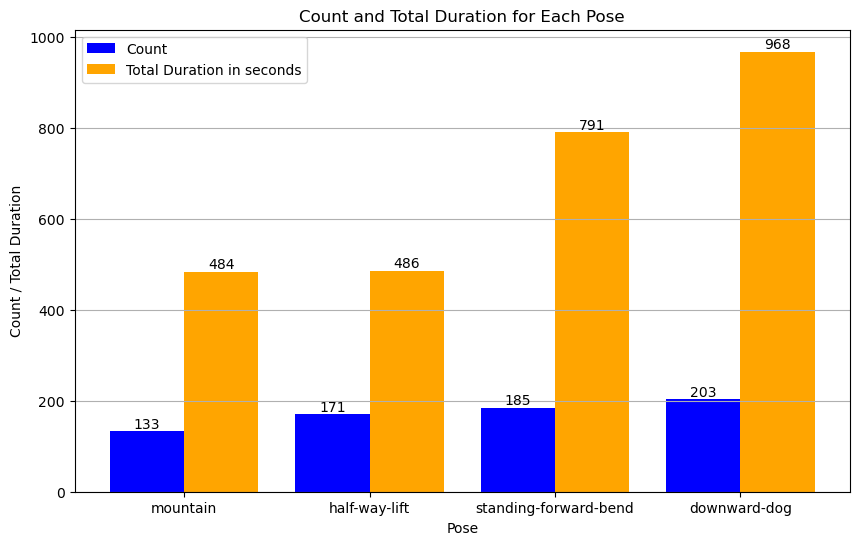

In [65]:
def plot_count_plus_duration(stats):
    # Extracting data from the stats dictionary
    poses = list(stats.keys())
    counts = [value[0] for value in stats.values()]
    durations = [value[1] for value in stats.values()]

    # Setting the x-axis positions
    x = range(len(poses))

    # Creating a bar plot for counts and durations
    plt.figure(figsize=(10, 6))
    bars1 = plt.bar(x, counts, width=0.4, label='Count', color='blue', align='center')
    bars2 = plt.bar([p + 0.4 for p in x], durations, width=0.4, label='Total Duration in seconds', color='orange', align='center')

    # Adding labels and title
    plt.xlabel('Pose')
    plt.ylabel('Count / Total Duration')
    plt.title('Count and Total Duration for Each Pose')
    plt.xticks([p + 0.2 for p in x], poses)  # Centering the x-ticks
    plt.legend()
    plt.grid(axis='y')

    # Adding raw numbers on top of the bars
    for bar in bars1:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')  # Count

    for bar in bars2:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')  # Total Duration

    # Show the plot
    plt.show()

# Call the function with your dataset_stats
plot_count_plus_duration(dataset_stats)

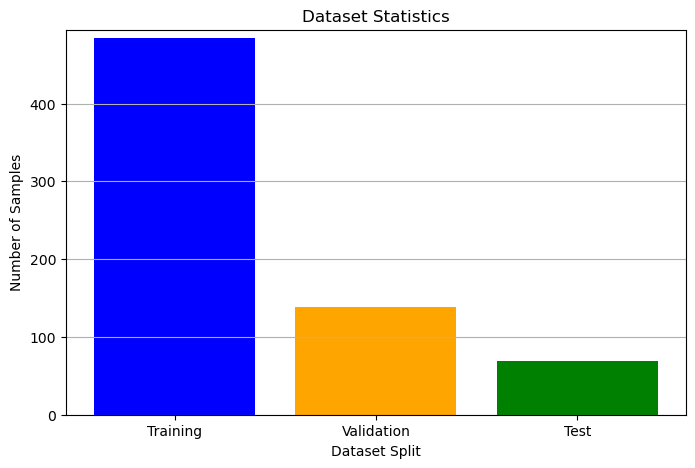

In [63]:
plot_dataset_statistics(train_d, val_d, test_d)